In [1]:
import os
import openai
from openai import OpenAI
import pandas as pd
import numpy as np
import tqdm
import copy
from emoatlas import EmoScores
import matplotlib.pyplot as plt
emos = EmoScores()

In [2]:
from collections import namedtuple
import nltk
from nrclex import NRCLex
import plotly.express as px
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/andrea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/andrea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
story_original = "Through history, most people didn't die of cancer or heart disease, the lifestyle diseases that are common in the Western world today. This is mostly because people didn't live long enough to develop them. They died of injuries -- being gored by an ox, shot on a battlefield, crushed in one of the new factories of the Industrial Revolution -- and most of the time from infection, which followed those injuries.\n\nThat changed when antibiotics were discovered. In 1928, Alexander Fleming discovered penicillin, a drug still used today to fight bacterial infections. Suddenly, infections that had been a death sentence became remedied within days. During World War II, this drug treated pneumonia and sepsis, and has been estimated to have saved between 12-15% of Allied Forces lives. We have been living inside the golden epoch of the miracle drugs, and now, we are coming to an end of it.\n\nPeople are dying of infections again because of a phenomenon called antibiotic resistance, or popularly referred to as “superbugs”. Bacteria compete against each other for resources, for food, by manufacturing lethal compounds that they direct against each other. When we first made antibiotics, we took those compounds into the lab and made our own versions of them, and bacteria responded to our attack the way they always had.\n\nFor 70 years, we played a game of leapfrog -- our drug and their resistance, and then another drug, and then resistance again -- and now the game is ending. Bacteria develop resistance so quickly that pharmaceutical companies have decided making antibiotics is not in their best interest, so there are infections moving across the world for which, out of the more than 100 antibiotics available on the market, two drugs might work with side effects, or one drug, or none.\n\nIt would be natural to hope that these infections are extraordinary cases, but in fact, in the United States and Europe, 50 thousand people a year die of infections which no drugs can help. A project chartered by the British government known as the Review on Antimicrobial Resistance estimates that the worldwide toll right now is 700 thousand deaths a year. Also, if we can't get this under control by 2050, the worldwide toll will be 10 million deaths a year (more than the current population of New York City).\n\nThe scale of antibiotic resistance seems overwhelming, but if you've ever bought a fluorescent light bulb because you were concerned about climate change, you already know what it feels like to take a tiny step to address an overwhelming problem. We could take those kinds of steps for antibiotic use too. We could forgo giving an antibiotic for our kids’ ear infection, if we're not sure it's the right one. And we could promise each other to never again to buy chicken or shrimp or fruit raised with routine antibiotic use. If we did those things, we could slow down the arrival of the post-antibiotic world."
story_original = story_original.replace("\n"," ")

In [4]:
path_data_files = "../cleaned_data/"
results=pd.read_csv(f'{path_data_files}/cleaned_combined_data.csv')

In [5]:
results_without_pilot=results[results['condition'].isin(['chain','network'])]

## Method 1: NRC Emotion Lexicon

In [6]:
list_NRC_emotions =list(NRCLex(story_original).affect_frequencies.keys())
list_NRC_emotions.remove('anticipation')
list_all_emotions_NRC = []
for story in tqdm.tqdm(list(results_without_pilot['story_merged'])):
    current_NRC_emotions = NRCLex(story).affect_frequencies
    list_all_emotions_NRC.append([current_NRC_emotions[emo] for emo in list_NRC_emotions])
results_without_pilot_NRC= copy.deepcopy(results_without_pilot)
results_without_pilot_NRC.reset_index(drop=True, inplace=True)
results_with_emotion_NRC = pd.concat([results_without_pilot_NRC, pd.DataFrame(np.matrix(list_all_emotions_NRC))], axis=1)
results_with_emotion_NRC.columns=list(results_without_pilot_NRC.columns)+list_NRC_emotions



100%|████████████████████████████████████████| 864/864 [00:01<00:00, 758.19it/s]


In [7]:
def NRC_emotion_over_generations(results_with_emotion,emotion_names,emo='anticipation'):
    chain_emotions=[]
    network_emotions=[]
    for l in range(1,6+1):
        emo_score_mean=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='chain')][emotion_names].mean())[emo]
        emo_score_std=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='chain')][emotion_names].std())[emo]
        emo_score_min=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='chain')][emotion_names].min())[emo]
        emo_score_max=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='chain')][emotion_names].max())[emo]
        chain_emotions.append([emo_score_mean,emo_score_std,emo_score_min,emo_score_max,
                               len(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='chain')][emotion_names])])

        emo_score_mean=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='network')][emotion_names].mean())[emo]
        emo_score_std=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='network')][emotion_names].std())[emo]
        emo_score_min=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='network')][emotion_names].min())[emo]
        emo_score_max=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='network')][emotion_names].max())[emo]

        network_emotions.append([emo_score_mean,emo_score_std,emo_score_min,emo_score_max,
                                len(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='network')][emotion_names])])
    chain_emotions=np.array(chain_emotions)
    network_emotions=np.array(network_emotions)
    return(chain_emotions,network_emotions)

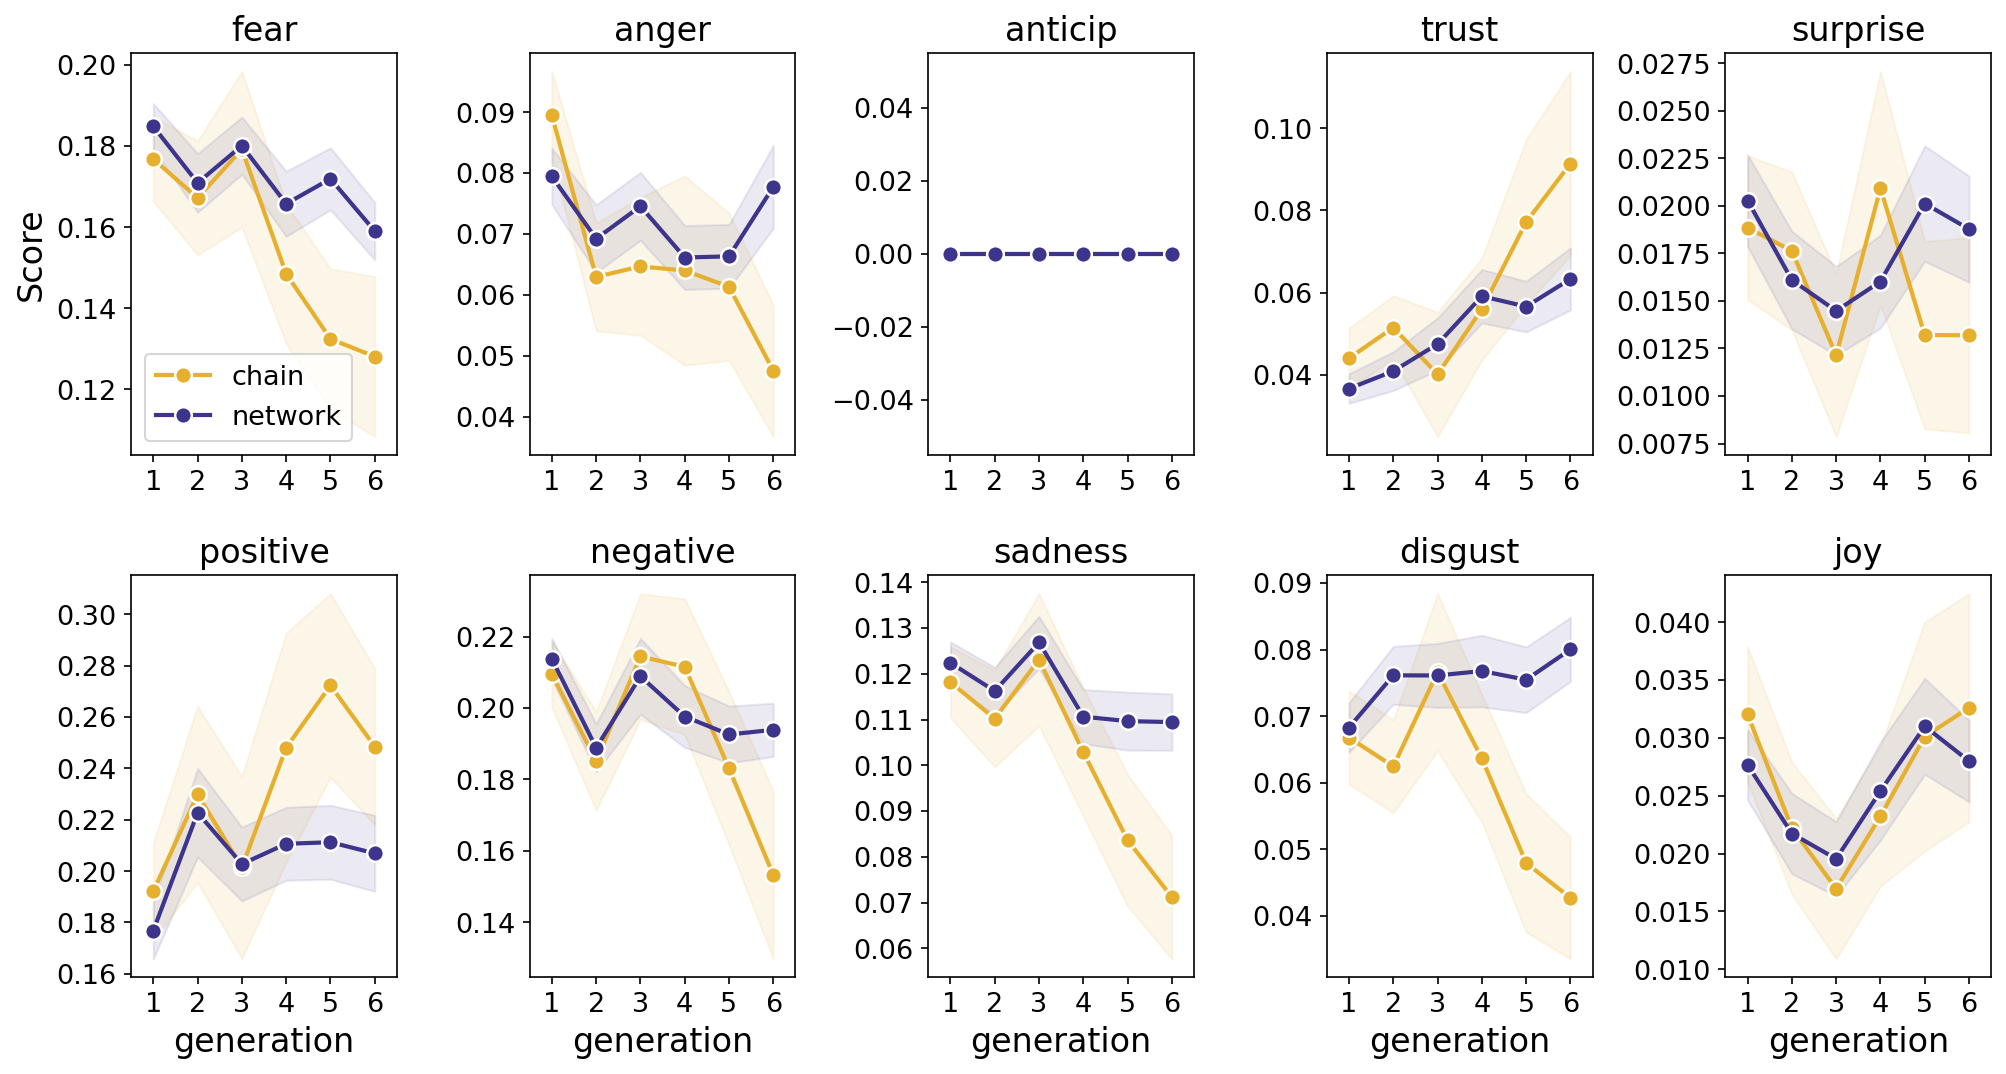

In [8]:
fig=plt.figure(dpi=150,figsize=(16,8))

fs_title=16
fs=13

for emo_idx,emo in enumerate(list_NRC_emotions):
    ax= plt.subplot(2,5,emo_idx+1)
    chain_emotions,network_emotions=NRC_emotion_over_generations(results_with_emotion_NRC,list_NRC_emotions,emo)
    

    plt.plot([1,2,3,4,5,6],chain_emotions[:,0],'o-',label='chain',
            color='#e6af2eff',markeredgecolor='white',markeredgewidth=1.2,markersize=8, linewidth=2)
    plt.fill_between([1,2,3,4,5,6],chain_emotions[:,0]-chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),
                     chain_emotions[:,0]+chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),alpha=0.1,color='#e6af2eff')


    plt.plot([1,2,3,4,5,6],network_emotions[:,0],'o-',label='network',
             color='#3d348bff',markeredgecolor='white',markeredgewidth=1.2,markersize=8, linewidth=2)
    plt.fill_between([1,2,3,4,5,6],network_emotions[:,0]-np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),
                     network_emotions[:,0]+np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),alpha=0.1,color='#3d348bff')
    
    
    
    if emo_idx == 0:
        plt.ylabel('Score',fontsize=fs_title)
        plt.legend(fontsize=fs)
    plt.title('%s' % emo,fontsize=fs_title)
    if emo_idx >=5:
        plt.xlabel('generation',fontsize=fs_title)
    plt.xlim(0.5,6.5)
    plt.xticks([1,2,3,4,5,6])
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
#     plt.ylim(0.5,5.5)
plt.subplots_adjust(wspace=0.5,hspace=0.3)
# plt.savefig('ChatGPT4.0_emotions_overtime.pdf',dpi=150,bbox_inches='tight')

## Method 2: Distil-RoBERTa-base

In [9]:
# import required packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

/home/andrea/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [10]:
# load tokenizer and model, create trainer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)


In [11]:
## Example on a simple text: the original story
pred_texts = story_original.split('.')[:-1]
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)
# Run predictions
predictions = trainer.predict(pred_dataset)
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)
# scores raw
temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))

# container
anger = []
disgust = []
fear = []
joy = []
neutral = []
sadness = []
surprise = []
# extract scores (as many entries as exist in pred_texts)
for i in range(len(pred_texts)):
  anger.append(temp[i][0])
  disgust.append(temp[i][1])
  fear.append(temp[i][2])
  joy.append(temp[i][3])
  neutral.append(temp[i][4])
  sadness.append(temp[i][5])
  surprise.append(temp[i][6])
# Create DataFrame with texts, predictions, labels, and scores
df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores,  anger, disgust, fear, joy, neutral, sadness, surprise)), columns=['text','pred','label','score', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])

In [12]:
def distilroberta(string):
    pred_texts = string.split('.')
    tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
    pred_dataset = SimpleDataset(tokenized_texts)
    # Run predictions
    predictions = trainer.predict(pred_dataset)
    # Transform predictions to labels
    preds = predictions.predictions.argmax(-1)
    labels = pd.Series(preds).map(model.config.id2label)
    scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)
    # scores raw
    temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))
    list_emotions=['anger','disgust','fear','joy','neutral','sadness','surprise']
    emotion_scores=np.zeros((len(pred_texts),7))
    for i in range(len(pred_texts)):
        for l in range(0,7):
            emotion_scores[i,l]=temp[i][l]

    r={i:np.mean(emotion_scores[:,idx]) for idx,i in enumerate(list_emotions)}
    return(r)

In [15]:
list_emotions_RoBERTa=['anger','disgust','fear','joy','neutral','sadness','surprise']
list_all_emotions_RoBERTa = []
for story in tqdm.notebook.tqdm(list(results_without_pilot['story_merged'])):
    current_RoBERTa_emotions = distilroberta(story)
    list_all_emotions_RoBERTa.append([current_RoBERTa_emotions[emo] for emo in list_emotions_RoBERTa])
results_without_pilot_RoBERTa= copy.deepcopy(results_without_pilot)
results_without_pilot_RoBERTa.reset_index(drop=True, inplace=True)
results_with_emotion_RoBERTa = pd.concat([results_without_pilot_RoBERTa, pd.DataFrame(np.matrix(list_all_emotions_RoBERTa))], axis=1)
results_with_emotion_RoBERTa.columns=list(results_without_pilot_RoBERTa.columns)+list_emotions_RoBERTa



  0%|          | 0/864 [00:00<?, ?it/s]

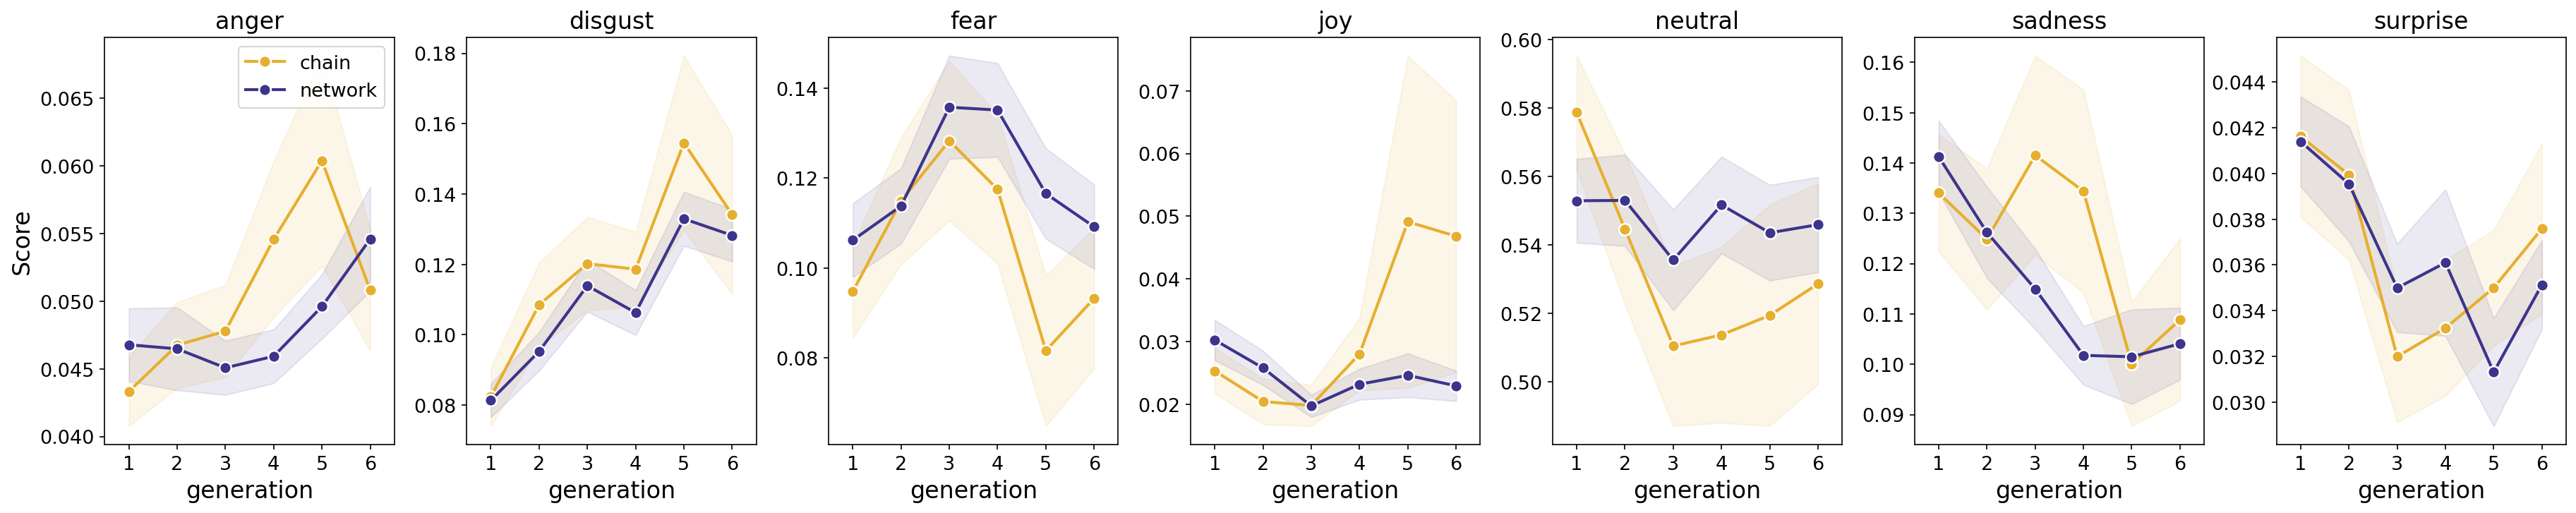

In [16]:
fig=plt.figure(dpi=150,figsize=(30,5))

fs_title=16
fs=13

for emo_idx,emo in enumerate(list_emotions_RoBERTa):
    ax= plt.subplot(1,7,emo_idx+1)
    chain_emotions,network_emotions=NRC_emotion_over_generations(results_with_emotion_RoBERTa,list_emotions_RoBERTa,emo)
    

    plt.plot([1,2,3,4,5,6],chain_emotions[:,0],'o-',label='chain',
            color='#e6af2eff',markeredgecolor='white',markeredgewidth=1.2,markersize=8, linewidth=2)
    plt.fill_between([1,2,3,4,5,6],chain_emotions[:,0]-chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),
                     chain_emotions[:,0]+chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),alpha=0.1,color='#e6af2eff')


    plt.plot([1,2,3,4,5,6],network_emotions[:,0],'o-',label='network',
             color='#3d348bff',markeredgecolor='white',markeredgewidth=1.2,markersize=8, linewidth=2)
    plt.fill_between([1,2,3,4,5,6],network_emotions[:,0]-np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),
                     network_emotions[:,0]+np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),alpha=0.1,color='#3d348bff')
    
    
    
    if emo_idx == 0:
        plt.ylabel('Score',fontsize=fs_title)
        plt.legend(fontsize=fs)
    plt.title('%s' % emo,fontsize=fs_title)
    
    plt.xlabel('generation',fontsize=fs_title)
    plt.xlim(0.5,6.5)
    plt.xticks([1,2,3,4,5,6])
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
#     plt.ylim(0.5,5.5)
plt.subplots_adjust(wspace=0.25)

## Method 3: Textual Forma Mentis Networks (TFMN)

In [17]:
max_dist=4
fmnt_chain_networks_all={'chain':{},'network':{}}
for cond in ['chain','network']:
    avg_emos_zscored={'anger': [],
                     'trust': [],
                     'surprise': [],
                     'disgust': [],
                     'joy': [],
                     'sadness': [],
                     'fear': [],
                     'anticipation': []}
    for value_thresh in [1]:
        for layer in tqdm.tqdm(range(1,6+1)):
            for story in  list(results[(results["condition"]==cond) & (results["layer_n"]==layer)]['story_merged']):
                fmnt = emos.formamentis_network(story,max_distance=max_dist,stopwords=stopwords.words('english')) 
                for k,val in emos.zscores(fmnt,n_samples=1000).items():
                    avg_emos_zscored[k].append(val)
                fmnt_chain_networks_all[cond][layer]=copy.deepcopy(avg_emos_zscored)


100%|█████████████████████████████████████████████| 6/6 [00:59<00:00,  9.99s/it]


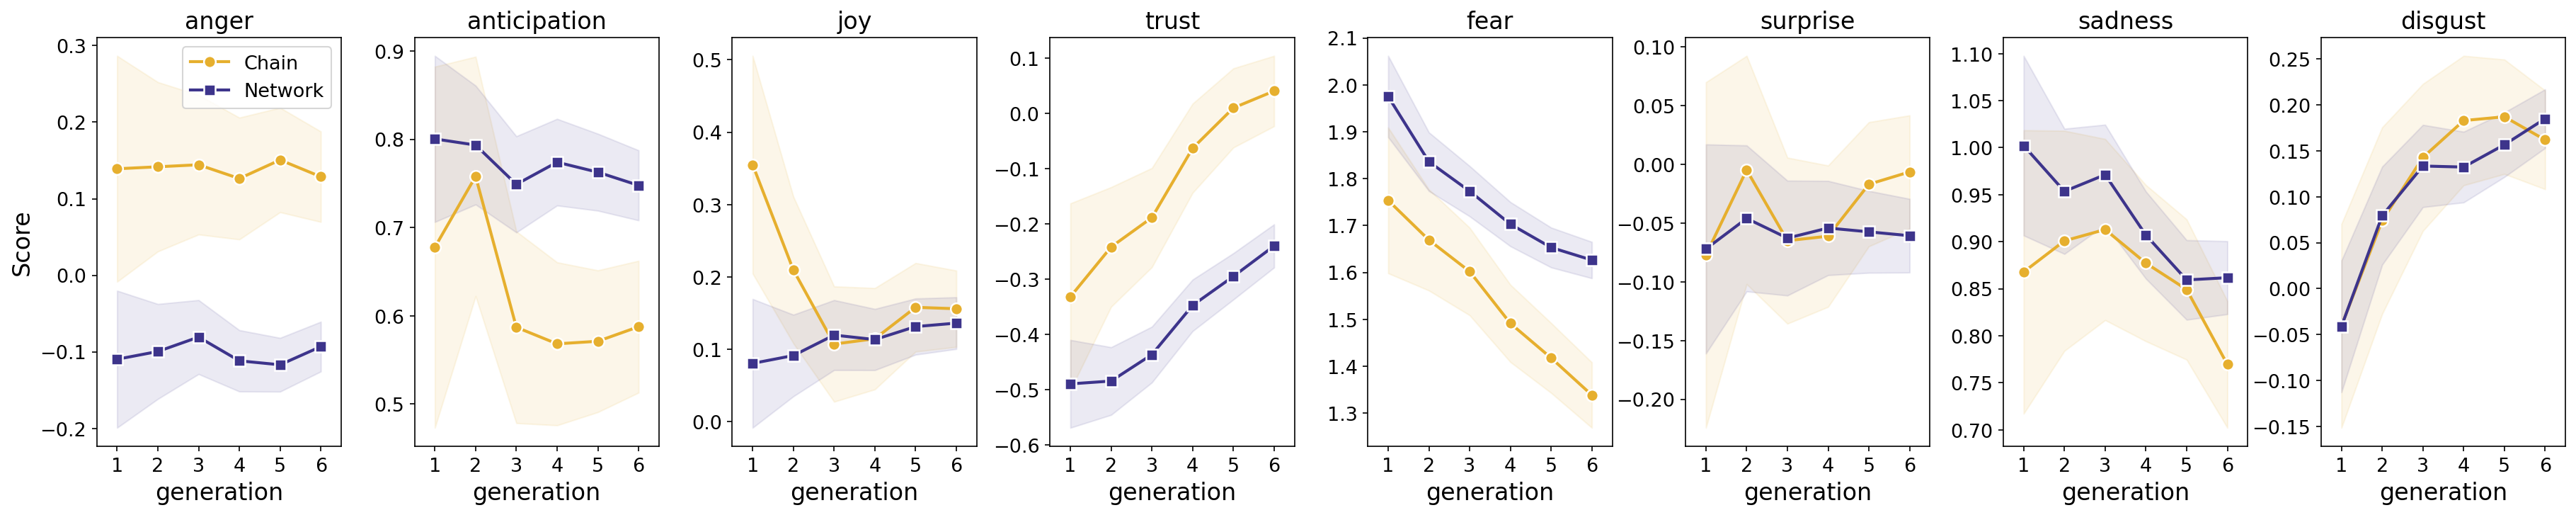

In [18]:
emotion_names=['anger','anticipation','joy','trust','fear','surprise','sadness','disgust']

fig=plt.figure(dpi=150,figsize=(30,5))
fs=13
fs_title=16
for emo_idx,emo in enumerate(emotion_names):
    ax= plt.subplot(1,8,emo_idx+1)
    plt.plot(range(1,7),[np.mean(fmnt_chain_networks_all['chain'][i][emo]) for i in range(1,7)],'o-',clip_on='False',label='Chain',
            color='#e6af2eff',markeredgecolor='white',markeredgewidth=1.2,markersize=8, linewidth=2)
    plt.fill_between(np.arange(1,6+1),[np.mean(fmnt_chain_networks_all['chain'][i][emo])-np.std(fmnt_chain_networks_all['chain'][i][emo])/np.sqrt(len(fmnt_chain_networks_all['chain'][i][emo])) for i in range(1,6+1)],
                  [np.mean(fmnt_chain_networks_all['chain'][i][emo])+np.std(fmnt_chain_networks_all['chain'][i][emo])/np.sqrt(len(fmnt_chain_networks_all['chain'][i][emo])) for i in range(1,6+1)],
                     color='#e6af2eff',alpha=0.1)    
    
    
    plt.plot(range(1,7),[np.mean(fmnt_chain_networks_all['network'][i][emo]) for i in range(1,7)],'s-',clip_on='False',label='Network',
            color='#3d348bff',markeredgecolor='white',markeredgewidth=1.2,markersize=8, linewidth=2)
    plt.fill_between(np.arange(1,6+1),[np.mean(fmnt_chain_networks_all['network'][i][emo])-np.std(fmnt_chain_networks_all['network'][i][emo])/np.sqrt(len(fmnt_chain_networks_all['network'][i][emo])) for i in range(1,6+1)],
                  [np.mean(fmnt_chain_networks_all['network'][i][emo])+np.std(fmnt_chain_networks_all['network'][i][emo])/np.sqrt(len(fmnt_chain_networks_all['network'][i][emo])) for i in range(1,6+1)],alpha=0.1,
                    color='#3d348bff')

    if emo_idx == 0:
        plt.ylabel('Score',fontsize=fs_title)
        plt.legend(fontsize=fs)
    plt.title('%s' % emo,fontsize=fs_title)
    plt.xlabel('generation',fontsize=fs_title)
    plt.xlim(0.5,6.5)
    plt.xticks([1,2,3,4,5,6])
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
#     plt.ylim(-0.6,2)

plt.subplots_adjust(wspace=0.3)
    

## Methods 4-5: ChatGPT 3.5 & 4.0

In [26]:
def chatgpt_enquiry(current_text,temperature=0,engine='gpt-3.5-turbo'):
    response = client.chat.completions.create(
                        model=engine,
                        messages=[{'role':'user', 'content':current_text}],
                        temperature=temperature,
                        timeout=10)
    return(response)


def emotion_detection(text,emotion,engine='gpt-3.5-turbo'):
    question='''How much {emo} is present in this text on a 1-7 scale? Answer only with a number,  with 1 being 'no {emo}' and 7 being 'a great deal of {emo}.' Here is the text:
    {text}'''.format(emo=emotion,text=text)
    
    
    response=chatgpt_enquiry(question,engine=engine)
    #print(question,response,response.choices[0].message.content)
    return(response.choices[0].message.content)



In [27]:
# api_key_location = os.path.expanduser("ChatGPT_txt.txt") 
# client = OpenAI(
#   api_key=open(api_key_location).read().strip(),
#  )

In [28]:
done = 1
if done == 0:
    ##ChatGPTcode
    list_all_emotions=[]
    for text in tqdm.tqdm(results_without_pilot['story_merged'][0:864]):
        current_emotion_list=[]
        for emo in emotion_names:
            rating=emotion_detection(text,emo)
            current_emotion_list.append(float(rating))
        list_all_emotions.append(current_emotion_list)
    np.save('emotion.npy', np.array(list_all_emotions))
else:
    results_with_emotion_35=pd.read_csv(f'result_with_ChatGPTemotions.csv')

In [29]:
### GPT 4.0

##ChatGPTcode
done = 1
if done == 0:
    list_all_emotions=[]
    for text in tqdm.tqdm(results_without_pilot['story_merged']):
        current_emotion_list=[]
        for emo in emotion_names:
            rating=emotion_detection(text,emo,engine='gpt-4')
            current_emotion_list.append(float(rating))
        list_all_emotions.append(current_emotion_list)
    np.save('emotion_GPT4.npy', np.array(list_all_emotions))
else:
    results_with_emotion_40=pd.read_csv(f'result_with_ChatGPT4emotions.csv')

In [30]:
def chatgpt_emotion_over_time(results_with_emotion,emotion_names,emo='anticipation'):
    chain_emotions=[]
    network_emotions=[]
    for l in range(1,6+1):
        emo_score_mean=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='chain')][emotion_names].mean())[emo]
        emo_score_std=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='chain')][emotion_names].std())[emo]
        emo_score_min=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='chain')][emotion_names].min())[emo]
        emo_score_max=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='chain')][emotion_names].max())[emo]
        chain_emotions.append([emo_score_mean,emo_score_std,emo_score_min,emo_score_max,
                               len(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='chain')][emotion_names])])

        emo_score_mean=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='network')][emotion_names].mean())[emo]
        emo_score_std=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='network')][emotion_names].std())[emo]
        emo_score_min=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='network')][emotion_names].min())[emo]
        emo_score_max=dict(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='network')][emotion_names].max())[emo]

        network_emotions.append([emo_score_mean,emo_score_std,emo_score_min,emo_score_max,
                                len(results_with_emotion[(results_with_emotion['layer_n']==l) & 
                             (results_with_emotion['condition']=='network')][emotion_names])])
    chain_emotions=np.array(chain_emotions)
    network_emotions=np.array(network_emotions)
    return(chain_emotions,network_emotions)

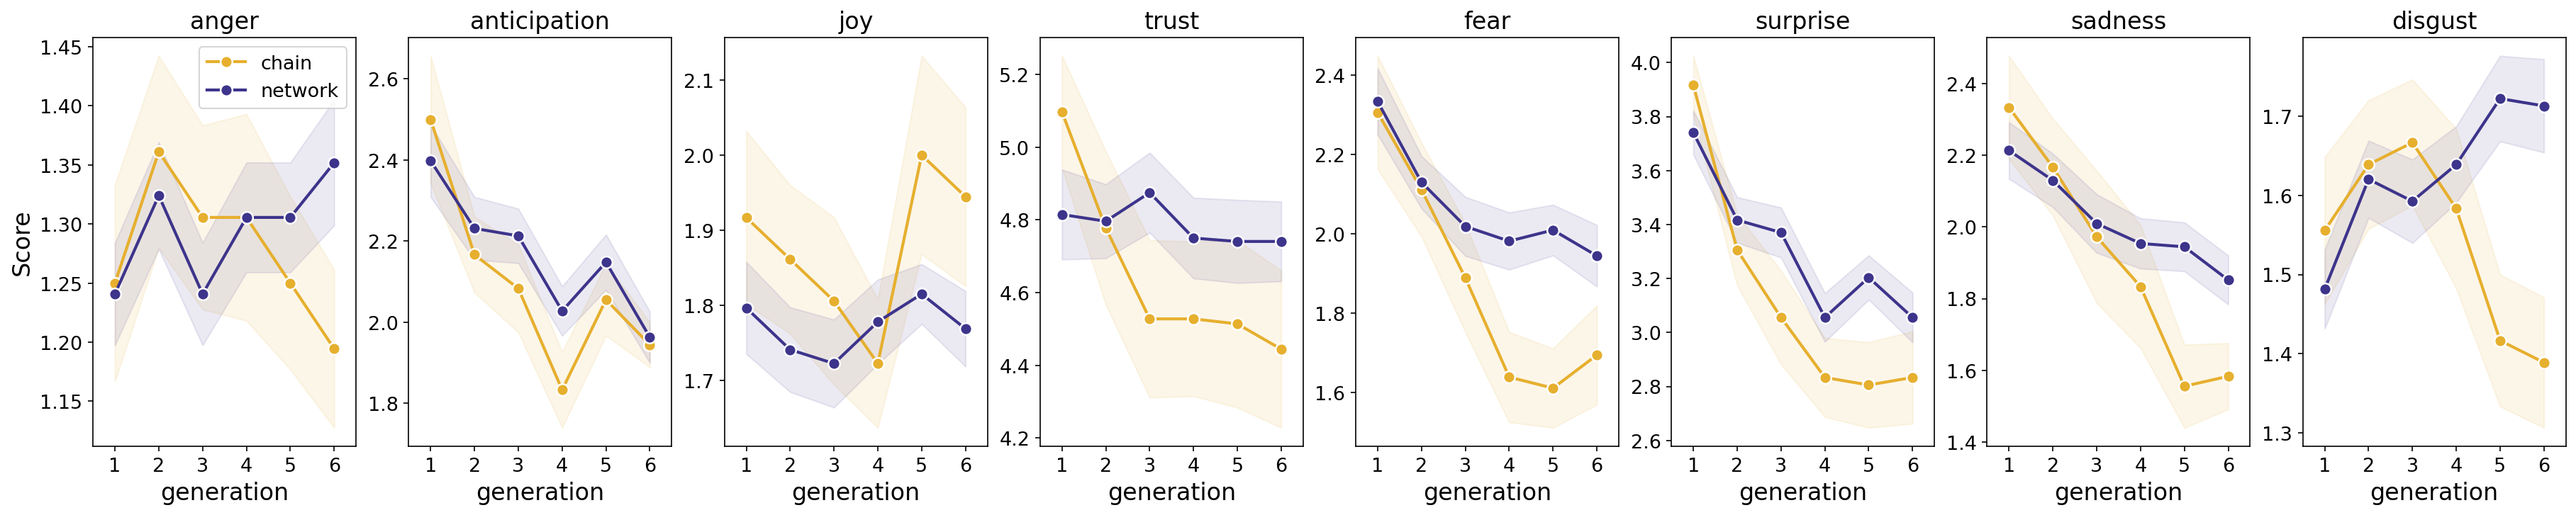

In [31]:
fig=plt.figure(dpi=150,figsize=(30,5))

for emo_idx,emo in enumerate(emotion_names):
    ax= plt.subplot(1,8,emo_idx+1)
    chain_emotions,network_emotions=chatgpt_emotion_over_time(results_with_emotion_35,emotion_names,emo)

    plt.plot([1,2,3,4,5,6],chain_emotions[:,0],'o-',label='chain',
            color='#e6af2eff',markeredgecolor='white',markeredgewidth=1.2,markersize=8, linewidth=2)
    plt.fill_between([1,2,3,4,5,6],chain_emotions[:,0]-chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),
                     chain_emotions[:,0]+chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),alpha=0.1,color='#e6af2eff')


    plt.plot([1,2,3,4,5,6],network_emotions[:,0],'o-',label='network',
             color='#3d348bff',markeredgecolor='white',markeredgewidth=1.2,markersize=8, linewidth=2)
    plt.fill_between([1,2,3,4,5,6],network_emotions[:,0]-np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),
                     network_emotions[:,0]+np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),alpha=0.1,color='#3d348bff')
    
    
    
    if emo_idx == 0:
        plt.ylabel('Score',fontsize=fs_title)
        plt.legend(fontsize=fs)
    plt.title('%s' % emo,fontsize=fs_title)
    plt.xlabel('generation',fontsize=fs_title)
    plt.xlim(0.5,6.5)
    plt.xticks([1,2,3,4,5,6])
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
#     plt.ylim(0.5,5.5)
    
# plt.savefig('ChatGPT4.0_emotions_overtime.pdf',dpi=150,bbox_inches='tight')

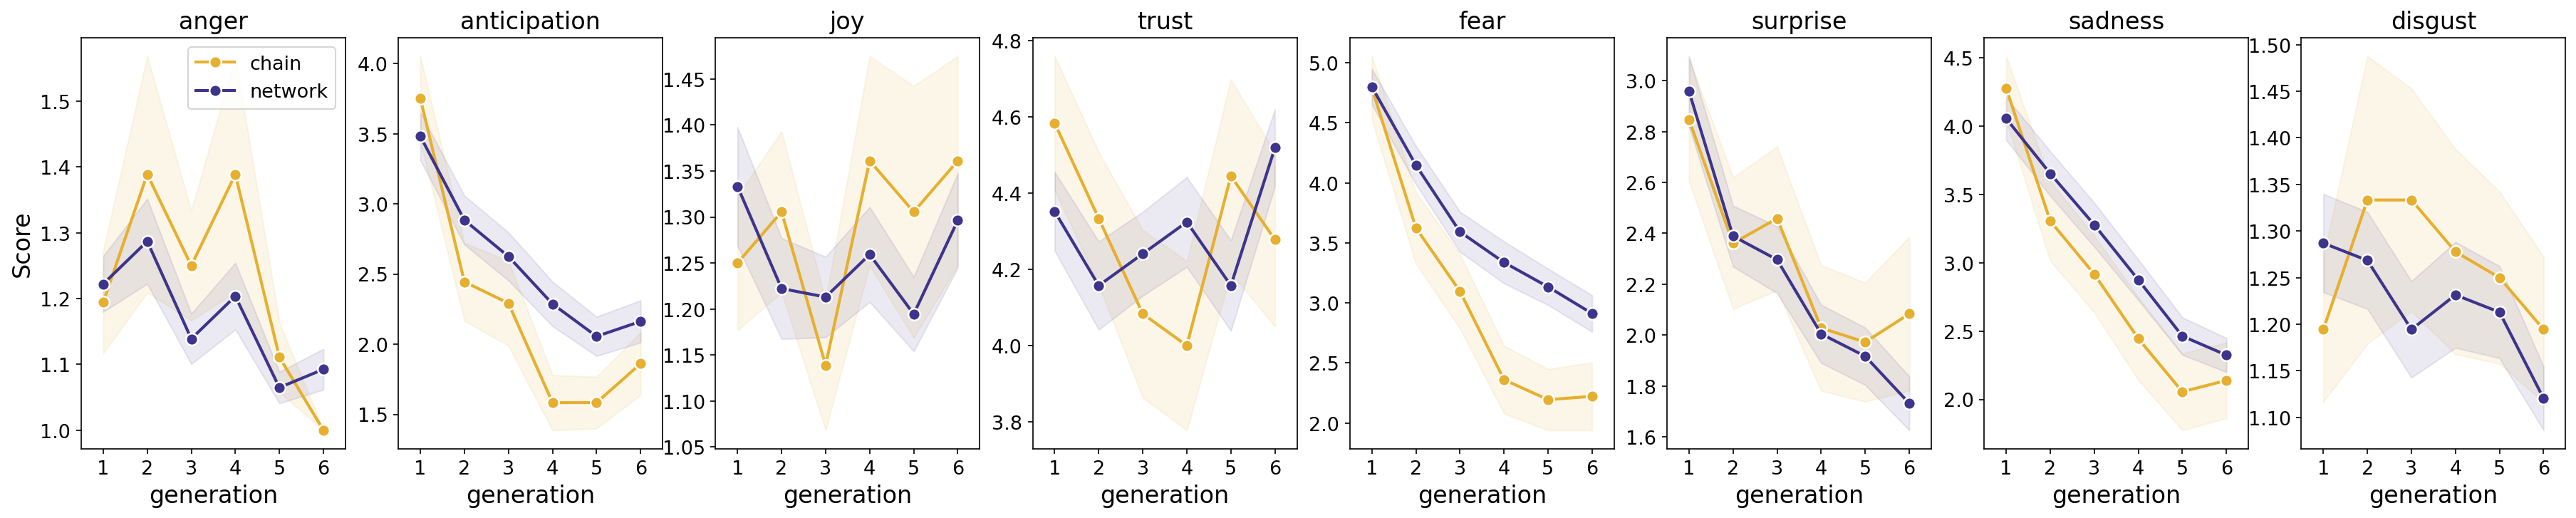

In [32]:
fig=plt.figure(dpi=150,figsize=(30,5))

for emo_idx,emo in enumerate(emotion_names):
    ax= plt.subplot(1,8,emo_idx+1)
    chain_emotions,network_emotions=chatgpt_emotion_over_time(results_with_emotion_40,emotion_names,emo)

    plt.plot([1,2,3,4,5,6],chain_emotions[:,0],'o-',label='chain',
            color='#e6af2eff',markeredgecolor='white',markeredgewidth=1.2,markersize=8, linewidth=2)
    plt.fill_between([1,2,3,4,5,6],chain_emotions[:,0]-chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),
                     chain_emotions[:,0]+chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),alpha=0.1,color='#e6af2eff')


    plt.plot([1,2,3,4,5,6],network_emotions[:,0],'o-',label='network',
             color='#3d348bff',markeredgecolor='white',markeredgewidth=1.2,markersize=8, linewidth=2)
    plt.fill_between([1,2,3,4,5,6],network_emotions[:,0]-np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),
                     network_emotions[:,0]+np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),alpha=0.1,color='#3d348bff')
    
    
    
    if emo_idx == 0:
        plt.ylabel('Score',fontsize=fs_title)
        plt.legend(fontsize=fs)
    plt.title('%s' % emo,fontsize=fs_title)
    plt.xlabel('generation',fontsize=fs_title)
    plt.xlim(0.5,6.5)
    plt.xticks([1,2,3,4,5,6])
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
#     plt.ylim(0.5,5.5)
    
# plt.savefig('ChatGPT4.0_emotions_overtime.pdf',dpi=150,bbox_inches='tight')

### Method 6: Gemini 1.0

In [33]:
import pathlib
import textwrap

import google.generativeai as genai


In [34]:
api_key_location = os.path.expanduser("gemini.txt") 
api_key=open(api_key_location).read().strip()
genai.configure(api_key=api_key)



In [35]:
def emotion_detection_gemini(text,emotion,model='gemini-pro'):
    model = genai.GenerativeModel(model)
    question='''How much {emo} is present in this text on a 1-7 scale? Answer only with a number,  with 1 being 'no {emo}' and 7 being 'a great deal of {emo}.' Here is the text:
    {text}'''.format(emo=emotion,text=text)
    
    response = model.generate_content(question)
    return(response)


In [36]:
emotion_detection_gemini(story_original,'anger')

FailedPrecondition: 400 User location is not supported for the API use.

### All together

In [64]:
from matplotlib.ticker import FormatStrFormatter

In [131]:
def find_ticks_plot(ax,n=5):
    num_digits=int(np.abs(np.log10(ax.get_ylim()[1])))+1
    min_max_interval=[np.round(ax.get_ylim()[0]-1/(10**(num_digits+1)),num_digits+1),
                     np.round(ax.get_ylim()[1]+1/(10**(num_digits+1)),num_digits+1)]
    gap=min_max_interval[1]-min_max_interval[0]
    ticks=np.round(np.linspace(min_max_interval[0],min_max_interval[1],n),num_digits+1)
    return(ticks)
def fix_plot_ticks(ax,fs=16,n=3,lw=0,axis_width=1.2):
    xrange=[1,2,3,4,5,6]
    ax.set_xticks(xrange,xrange,fontsize=fs)
    ax.set_xlim(0.5,6)
    list_proper_ticks=find_ticks_plot(ax,n)
    ax.set_yticks(ticks=list_proper_ticks,labels=list_proper_ticks,fontsize=fs)
    ax.spines["top"].set_linewidth(lw)
    ax.spines["right"].set_linewidth(lw)
    ax.spines["left"].set_linewidth(axis_width)
    ax.spines["bottom"].set_linewidth(axis_width)
    ax.tick_params(direction='out', length=6, width=axis_width + 0.5, colors='k',
                   grid_color='k', grid_alpha=0.5, axis='both')
    ax.tick_params(direction='out', which='minor', length=8, width=axis_width + 0.5, colors='k',
                   grid_color='k', grid_alpha=0.5, axis='both')
    ax.tick_params(direction='out', which='major', length=8, colors='k',
                   grid_color='k', grid_alpha=0.5, axis='both')
    

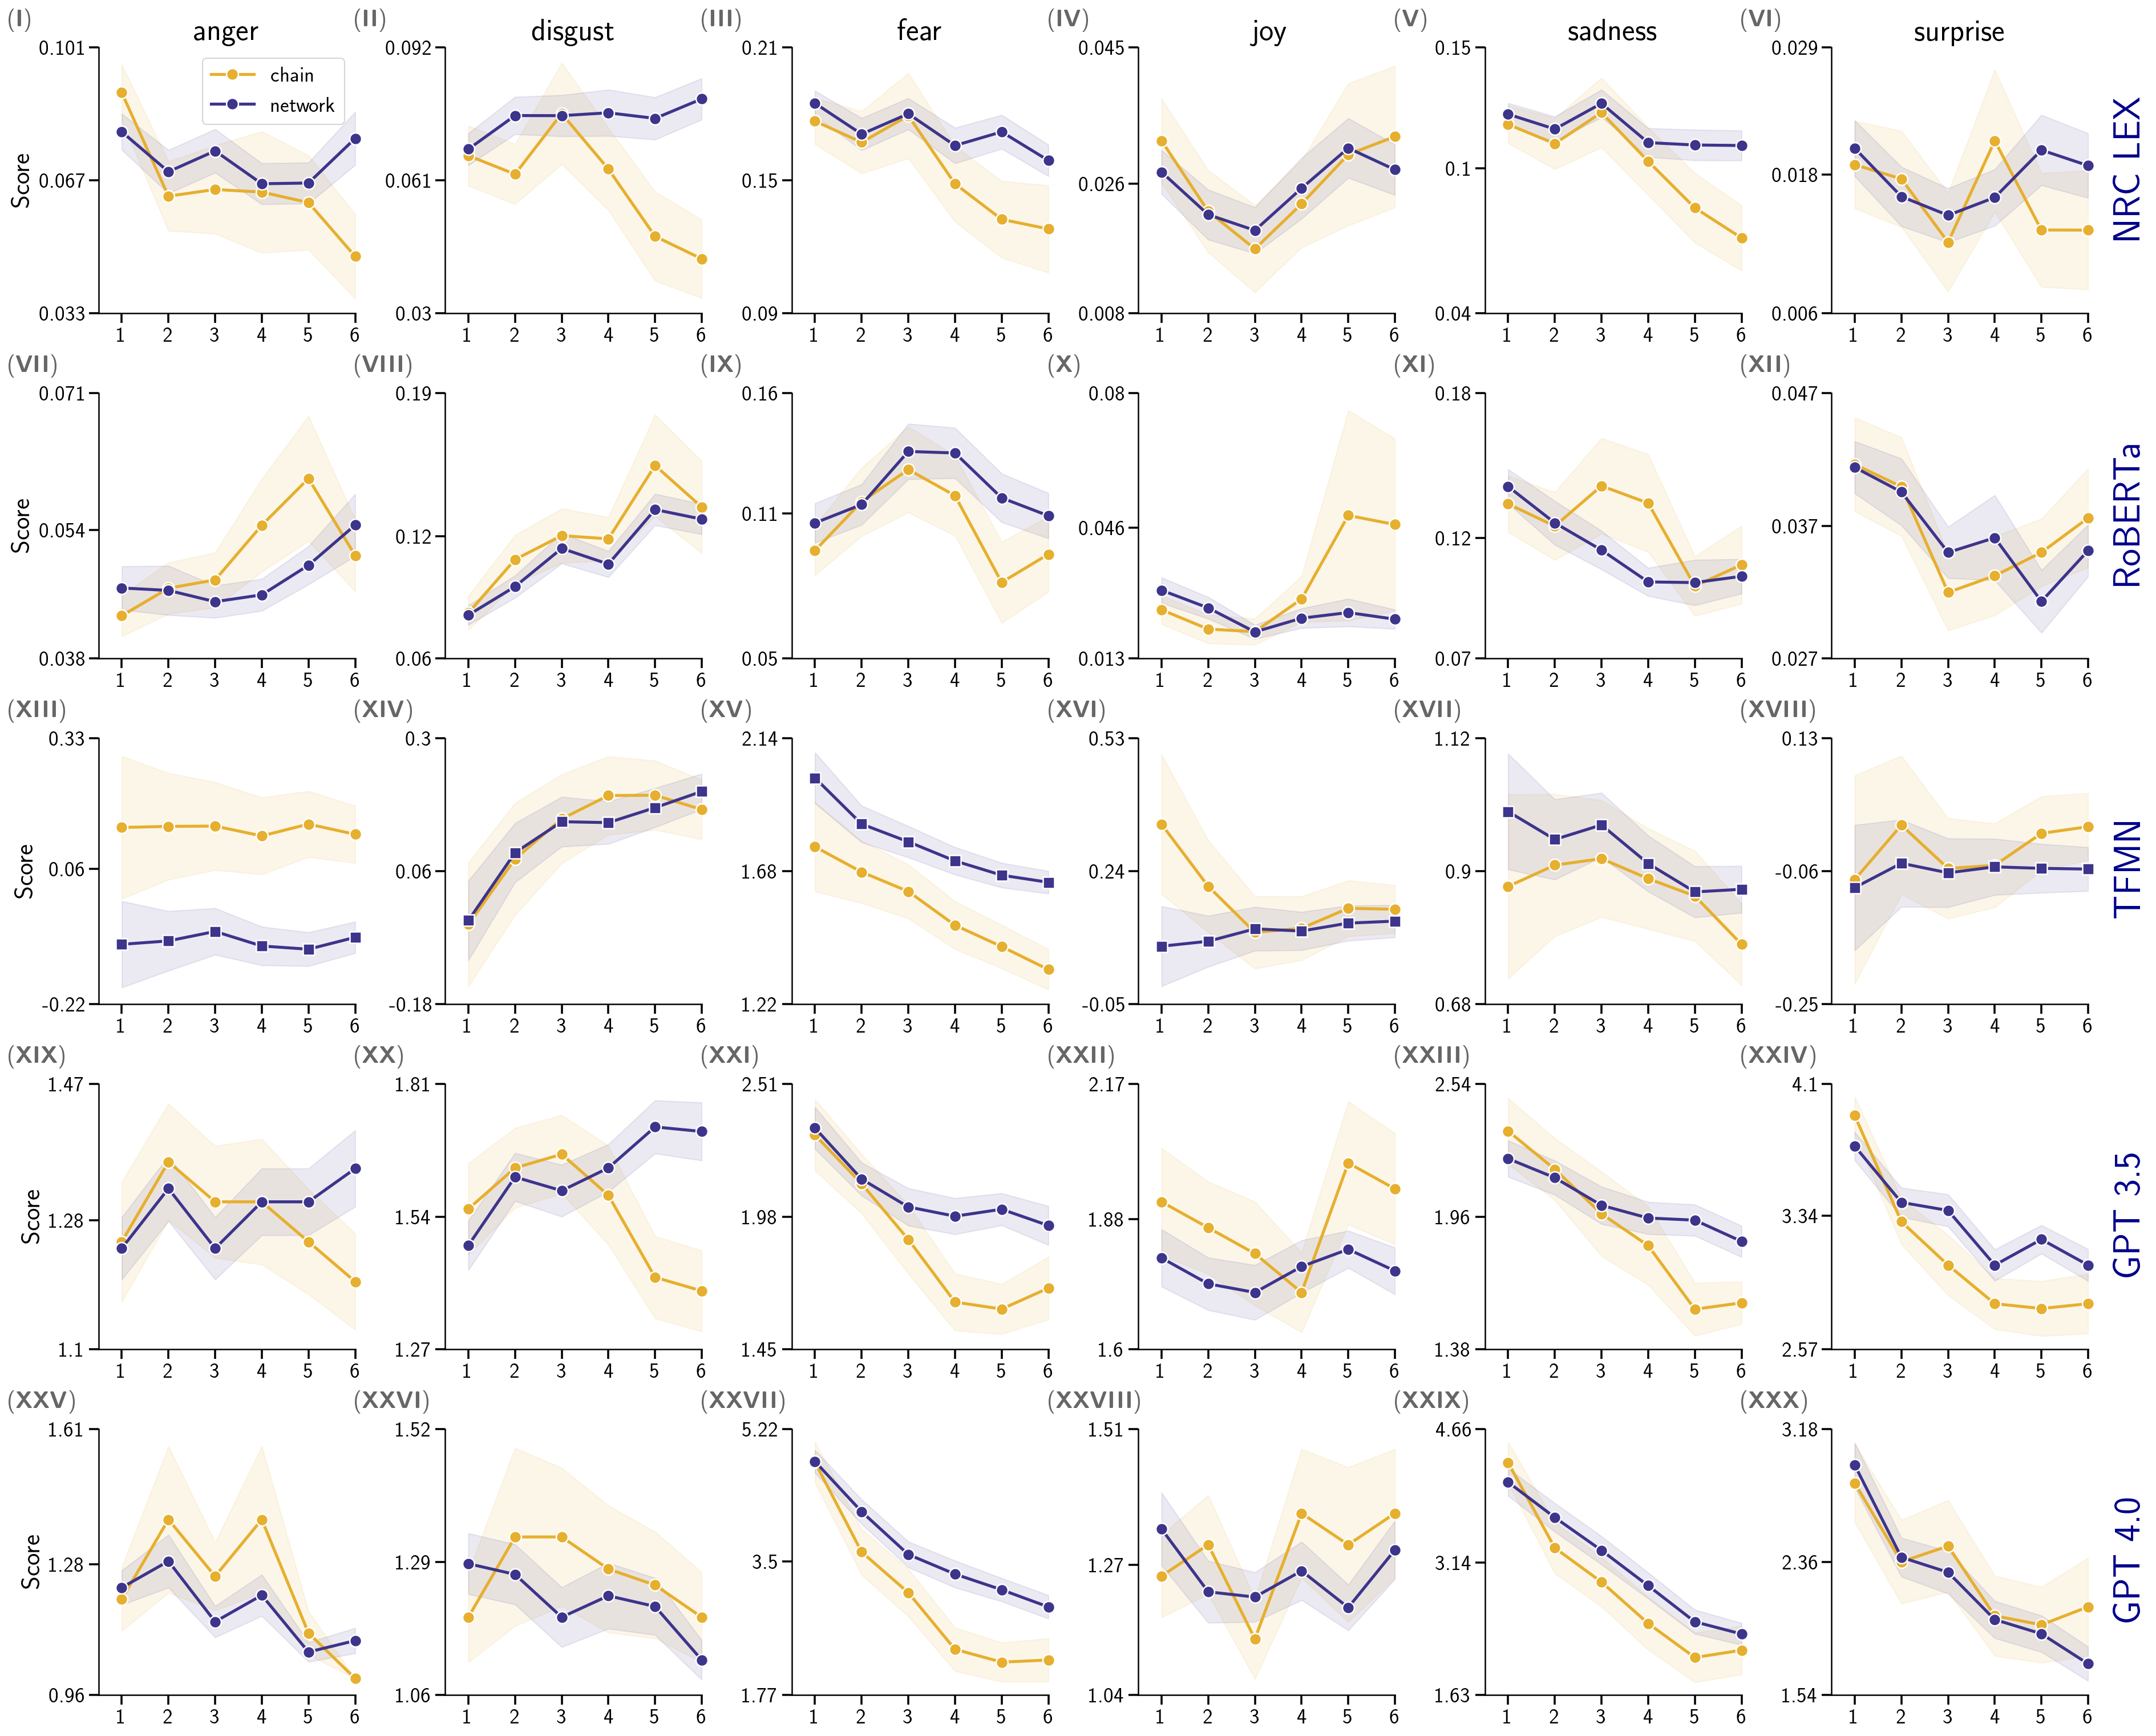

In [165]:
emotions=['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
# emotion_names=['anger','anticipation','joy','trust','fear','surprise','sadness','disgust']
nticks=3
fig=plt.figure(dpi=150,figsize=(30,25))
fs=18
fs_title=22
axis_width=1
lw_plot=2.5
markersize_plot=10
# labels = ["("+chr(64+x)+")" for x in np.arange(1,31)]
labels = [r'\rom{{{}}}'.format(i) for i in range(1,31)]
counter=0

# Turn on LaTeX formatting for text    
plt.rcParams['text.usetex']=True

# Place the command in the text.latex.preamble using rcParams
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{(\textbf{\expandafter\@slowromancap\romannumeral #1@})} \makeatother'

### METHOD 1: NRC LEX
for emo_idx,emo in enumerate(emotions):
    ax= plt.subplot(5,6,emo_idx+1)
    chain_emotions,network_emotions=NRC_emotion_over_generations(results_with_emotion_NRC,emotions,emo)
    plt.plot([1,2,3,4,5,6],chain_emotions[:,0],'o-',label='chain',
            color='#e6af2eff',markeredgecolor='white',markeredgewidth=1.2,markersize=markersize_plot, linewidth=lw_plot,clip_on=False)
    plt.fill_between([1,2,3,4,5,6],chain_emotions[:,0]-chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),
                     chain_emotions[:,0]+chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),alpha=0.1,color='#e6af2eff')


    plt.plot([1,2,3,4,5,6],network_emotions[:,0],'o-',label='network',
             color='#3d348bff',markeredgecolor='white',markeredgewidth=1.2,markersize=markersize_plot, linewidth=lw_plot,clip_on=False)
    plt.fill_between([1,2,3,4,5,6],network_emotions[:,0]-np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),
                     network_emotions[:,0]+np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),alpha=0.1,color='#3d348bff')
    
    
    if emo_idx == 0:
        plt.ylabel('Score',fontsize=fs_title)
        plt.legend(fontsize=18)
    plt.title('%s' % emo,fontsize=fs_title+4)
    fix_plot_ticks(ax,fs=fs)
    plt.text(x=-0.35,y=1.08, s=labels[counter],fontsize=20,color='k',alpha=0.6,
             transform = ax.transAxes,weight='bold',clip_on=False)
    counter+=1
plt.text(x=1.1,y=0.3, s='NRC LEX',fontsize=32,rotation=90,color='darkblue',transform = ax.transAxes)




####Method 2: Distil-RoBERTa 
for emo_idx,emo in enumerate(emotions):
    ax= plt.subplot(5,6,6 + emo_idx+1)
    chain_emotions,network_emotions=NRC_emotion_over_generations(results_with_emotion_RoBERTa,emotions,emo)
    
    plt.plot([1,2,3,4,5,6],chain_emotions[:,0],'o-',label='chain',
            color='#e6af2eff',markeredgecolor='white',markeredgewidth=1.2,markersize=markersize_plot, linewidth=lw_plot,clip_on=False)
    plt.fill_between([1,2,3,4,5,6],chain_emotions[:,0]-chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),
                     chain_emotions[:,0]+chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),alpha=0.1,color='#e6af2eff')


    plt.plot([1,2,3,4,5,6],network_emotions[:,0],'o-',label='network',
             color='#3d348bff',markeredgecolor='white',markeredgewidth=1.2,markersize=markersize_plot, linewidth=lw_plot,clip_on=False)
    plt.fill_between([1,2,3,4,5,6],network_emotions[:,0]-np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),
                     network_emotions[:,0]+np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),alpha=0.1,color='#3d348bff')
    
    
    
    if emo_idx == 0:
        plt.ylabel('Score',fontsize=fs_title,)
    fix_plot_ticks(ax,fs=fs)
    plt.text(x=-0.35,y=1.08, s=labels[counter],fontsize=20,color='k',alpha=0.6,
             transform = ax.transAxes,weight='bold',clip_on=False)
    counter+=1
plt.text(x=1.1,y=0.3, s='RoBERTa',fontsize=32,rotation=90,color='darkblue',transform = ax.transAxes)    


####Method 3: TFMN 
for emo_idx,emo in enumerate(emotions):
    ax= plt.subplot(5,6,12+emo_idx+1)
    plt.plot(range(1,7),[np.mean(fmnt_chain_networks_all['chain'][i][emo]) for i in range(1,7)],'o-',label='Chain',
            color='#e6af2eff',markeredgecolor='white',markeredgewidth=1.2,markersize=markersize_plot, linewidth=lw_plot,clip_on=False)
    plt.fill_between(np.arange(1,6+1),[np.mean(fmnt_chain_networks_all['chain'][i][emo])-np.std(fmnt_chain_networks_all['chain'][i][emo])/np.sqrt(len(fmnt_chain_networks_all['chain'][i][emo])) for i in range(1,6+1)],
                  [np.mean(fmnt_chain_networks_all['chain'][i][emo])+np.std(fmnt_chain_networks_all['chain'][i][emo])/np.sqrt(len(fmnt_chain_networks_all['chain'][i][emo])) for i in range(1,6+1)],
                     color='#e6af2eff',alpha=0.1)    
    
    
    plt.plot(range(1,7),[np.mean(fmnt_chain_networks_all['network'][i][emo]) for i in range(1,7)],'s-',label='Network',
            color='#3d348bff',markeredgecolor='white',markeredgewidth=1.2,markersize=markersize_plot, linewidth=lw_plot,clip_on=False)
    plt.fill_between(np.arange(1,6+1),[np.mean(fmnt_chain_networks_all['network'][i][emo])-np.std(fmnt_chain_networks_all['network'][i][emo])/np.sqrt(len(fmnt_chain_networks_all['network'][i][emo])) for i in range(1,6+1)],
                  [np.mean(fmnt_chain_networks_all['network'][i][emo])+np.std(fmnt_chain_networks_all['network'][i][emo])/np.sqrt(len(fmnt_chain_networks_all['network'][i][emo])) for i in range(1,6+1)],alpha=0.1,
                    color='#3d348bff')

    if emo_idx == 0:
        plt.ylabel('Score',fontsize=fs_title)
    fix_plot_ticks(ax,fs=fs)
    plt.text(x=-0.35,y=1.08, s=labels[counter],fontsize=20,color='k',alpha=0.6,
             transform = ax.transAxes,weight='bold',clip_on=False)
    counter+=1
plt.text(x=1.1,y=0.35, s='TFMN',fontsize=32,rotation=90,color='darkblue',transform = ax.transAxes)


### Method 4: GPT 3.5
for emo_idx,emo in enumerate(emotions):
    ax= plt.subplot(5,6,18+emo_idx+1)
    chain_emotions,network_emotions=chatgpt_emotion_over_time(results_with_emotion_35,emotion_names,emo)

    plt.plot([1,2,3,4,5,6],chain_emotions[:,0],'o-',label='chain',
            color='#e6af2eff',markeredgecolor='white',markeredgewidth=1.2,markersize=markersize_plot, linewidth=lw_plot,clip_on=False)
    plt.fill_between([1,2,3,4,5,6],chain_emotions[:,0]-chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),
                     chain_emotions[:,0]+chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),alpha=0.1,color='#e6af2eff')


    plt.plot([1,2,3,4,5,6],network_emotions[:,0],'o-',label='network',
             color='#3d348bff',markeredgecolor='white',markeredgewidth=1.2,markersize=markersize_plot, linewidth=lw_plot,clip_on=False)
    plt.fill_between([1,2,3,4,5,6],network_emotions[:,0]-np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),
                     network_emotions[:,0]+np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),alpha=0.1,color='#3d348bff')
    
    if emo_idx == 0:
        plt.ylabel('Score',fontsize=fs_title)
    fix_plot_ticks(ax,fs=fs)
    plt.text(x=-0.35,y=1.08, s=labels[counter],fontsize=20,color='k',alpha=0.6,
             transform = ax.transAxes,weight='bold',clip_on=False)
    counter+=1
plt.text(x=1.1,y=0.3, s='GPT 3.5',fontsize=32,rotation=90,color='darkblue',transform = ax.transAxes)



### Method 5: GPT 3.5
for emo_idx,emo in enumerate(emotions):
    ax= plt.subplot(5,6,24+emo_idx+1)
    chain_emotions,network_emotions=chatgpt_emotion_over_time(results_with_emotion_40,emotion_names,emo)

    plt.plot([1,2,3,4,5,6],chain_emotions[:,0],'o-',label='chain',
            color='#e6af2eff',markeredgecolor='white',markeredgewidth=1.2,markersize=markersize_plot, linewidth=lw_plot,clip_on=False)
    plt.fill_between([1,2,3,4,5,6],chain_emotions[:,0]-chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),
                     chain_emotions[:,0]+chain_emotions[:,1]/np.sqrt(chain_emotions[0,4]),alpha=0.1,color='#e6af2eff')


    plt.plot([1,2,3,4,5,6],network_emotions[:,0],'o-',label='network',
             color='#3d348bff',markeredgecolor='white',markeredgewidth=1.2,markersize=markersize_plot, linewidth=lw_plot,clip_on=False)
    plt.fill_between([1,2,3,4,5,6],network_emotions[:,0]-np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),
                     network_emotions[:,0]+np.array(network_emotions[:,1])/np.sqrt(network_emotions[0,4]),alpha=0.1,color='#3d348bff')
    
    
    
    if emo_idx == 0:
        plt.ylabel('Score',fontsize=fs_title)
    fix_plot_ticks(ax,fs=fs)
    plt.text(x=-0.35,y=1.08, s=labels[counter],fontsize=20,color='k',alpha=0.6,
             transform = ax.transAxes,weight='bold',clip_on=False)
    counter+=1
plt.text(x=1.1,y=0.3, s='GPT 4.0',fontsize=32,rotation=90,color='darkblue',transform = ax.transAxes)

plt.subplots_adjust(wspace=0.35,hspace=0.3)
plt.savefig('emotion_analysis.pdf',dpi=150,bbox_inches='tight')